In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model.PDV import *
from model.data import *

# Download data

In [2]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [5]:
spx_data = pd.read_csv('data/spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('data/vix_data.csv', index_col=0, parse_dates=[0])

In [6]:
data = create_df_from_yf(spx_data, train_start_date, test_start_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [7]:
window = 1000
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting

## SGD

In [8]:
# params = torch.tensor([0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5], requires_grad=True)
# optimizer = torch.optim.Adam([params], lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# for epoch in range(100):
#     losses = []
#     for x, y in dataloader:
#         preds = torch_predict(params, x)
#         loss = nn.MSELoss()(preds, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     epoch_loss = np.mean(losses)
#     print(f'Epoch {epoch} Loss {epoch_loss}')
#     scheduler.step(epoch_loss)

In [9]:
# print(params)
# evaluate(params.detach().numpy(), data, window)

## Least squares

In [10]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, window), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)
res.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3651e+00                                    2.35e+01    
       1              3         1.2768e+00      8.83e-02       2.11e+00       7.53e+00    
       2              4         1.2313e+00      4.55e-02       9.05e-01       1.82e-01    
       3              5         1.2244e+00      6.89e-03       4.99e+00       2.11e+00    
       4              6         1.2196e+00      4.79e-03       1.81e+00       1.91e-01    
       5              7         1.2173e+00      2.33e-03       4.87e+00       4.93e-01    
       6              8         1.2164e+00      9.38e-04       7.24e+00       3.71e-01    
       7              9         1.2159e+00      4.43e-04       7.24e+00       3.41e-01    
       8             10         1.2158e+00      1.27e-04       6.67e+00       1.89e-01    
       9             11         1.2158e+00      2.74e-05       6.55e-01       2.35e-03    

array([ 4.82545454e-02, -3.86411479e-02,  8.77448974e-01,  6.95118966e+01,
        1.63686427e+01,  8.18241748e-01,  1.42390732e+01,  1.65988269e+00,
        3.93864750e-01])

In [11]:
evaluate(res.x, data, window)

Mean: 0.0000, Min: -0.1149, Max: 0.1311, MAE: 0.0159, MSE: 0.0005, R^2: 0.9329


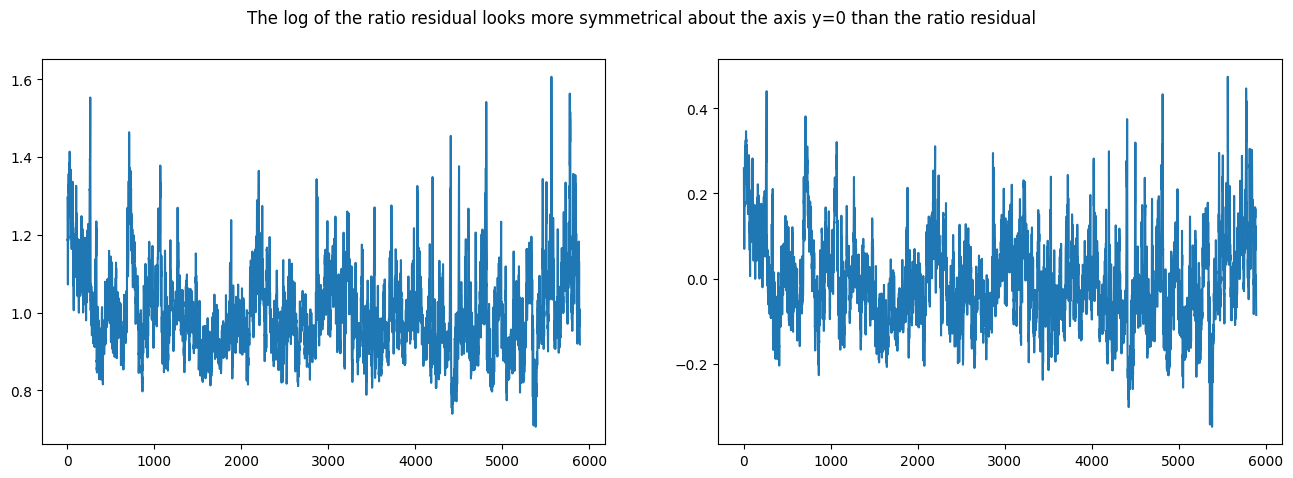

In [37]:
residuals, y_hat = residual(res.x, data, window, return_y_hat=True)
ratio = (residuals+y_hat)/y_hat
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(ratio)
ax[1].plot(np.log(ratio))
plt.suptitle('The log of the ratio residual looks more symmetrical about the axis y=0 than the ratio residual')
plt.show()

# Predicting out of sample

In [12]:
data = create_df_from_yf(spx_data, train_start_date, test_end_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475
2022-05-10,0.002455,6.026444e-06,0.3299
2022-05-11,-0.016600,2.755677e-04,0.3256
2022-05-12,-0.001297,1.681703e-06,0.3177


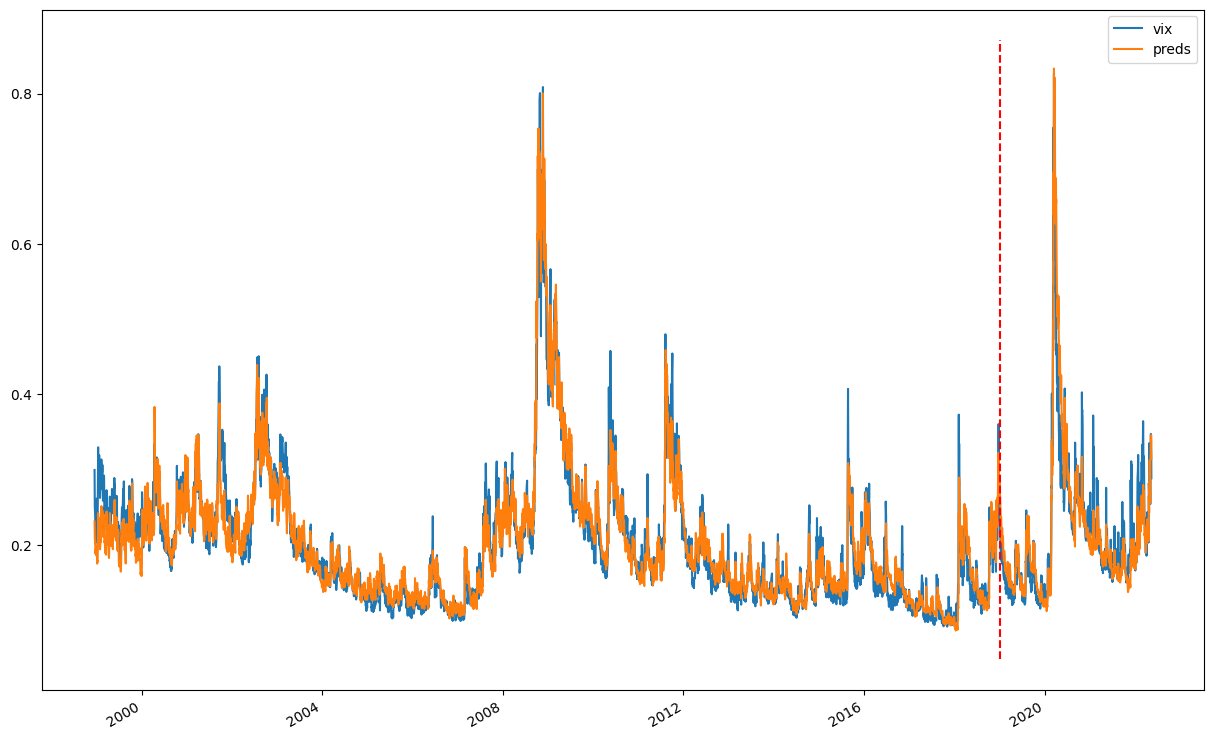

In [13]:
plot(res.x, data, window, test_start_date=test_start_date)